[__<< Feature Engineering__](./04-Cars4u_feature_engineering.ipynb) | [__Home__](../README.md)


# Cars4u: Car Price Prediction
## Modeling

__Dataset:__ [Cars4u](https://www.kaggle.com/datasets/sukhmanibedi/cars4u) \
__Author:__ Dmitry Luchkin \
__Date:__ 2024-08-02

__Objectives:__
   - Split the dataset into training and testing sets (80/20) to evaluate model performance.
   - Train various regression models to predict car prices.
   - Evaluate model performance using metrics such as Mean Squared Error (MSE), R-squared, etc.
   - Select the best-performing model based on evaluation metrics.
   - Validate the model's predictions against the actual prices.
   - Use the best model to make predictions op used cars price.

## Table of content

- [Notebooks](#notebooks)
- [Importing Libraries](#import-libraries)
- [Notebook Setup](#notebook-setup)
- [Loading Data](#loading-data)
- [Building Model](#building-model)
  - [Dummy Variables](#dummy-variables)
  - [Split Data](#split-data)
  - [Training Model](#fitting-model)
  - [Testing Model](#testing-model)
  - [Model Validation](#model-validation)
  - [Multicollinearity Test](#multicollinearity)
  - [Select Model](#select-model)
  - [Residuals Analysis](#residuals-analysis)
  - [Model Viz](#model-viz)
- [Model Interpretation](#model-interpretation)
- [Predict New Data](#predict-new-data)
- [Saving Final Model](#save-model)

## Notebooks <a name='#notebooks'></a>

+ [01_Cars4u_initial_data_exploration.ipynb](./01_Cars4u_initial_data_exploration.ipynb)
+ [02_Cars4u_data_cleaning.ipynb](./02_Cars4u_data_cleaning.ipynb)
+ [03_Cars4u_exploratory_data_analysis.ipynb](./03_Cars4u_exploratory_data_analysis.ipynb)
+ [04_Cars4u_feature_engineering.ipynb](./04_Cars4u_feature_engineering.ipynb)
+ [__05_Cars4u_modeling.ipynb__](./05_Cars4u_modeling.ipynb)

## Import Libraries <a name='#import-libraries'></a>

In [1]:
import sys
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
%matplotlib inline

## Notebook Setup <a name='#notebook-setup'></a>

In [2]:
# Pandas settings
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 60
pd.options.display.float_format = '{:,.4f}'.format

# Visualization settings
from matplotlib import rcParams
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = (16, 5)   
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['font.size'] = 12
rcParams['savefig.dpi'] = 300
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
%config InlineBackend.figure_format = 'retina'

## Loading Data <a name='#loading-data'></a>

In [3]:
# loading data
filename = '../00_data/02_processed/used_cars_data_processed_final.pkl'

with open(filename, 'rb') as file:
    data = pickle.load(file)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7250 entries, 0 to 7252
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   location                7250 non-null   category
 1   year                    7250 non-null   int64   
 2   kilometers_driven       7250 non-null   int64   
 3   fuel_type               7250 non-null   category
 4   transmission            7250 non-null   category
 5   owner_type              7250 non-null   category
 6   engine_cc               7250 non-null   float64 
 7   power_bhp               7250 non-null   float64 
 8   seats                   7250 non-null   float64 
 9   price_lakh              6016 non-null   float64 
 10  brand                   7250 non-null   category
 11  model                   7250 non-null   category
 12  mileage_kmpl            7250 non-null   float64 
 13  new_car_price_lakh      7250 non-null   float64 
 14  previous_owners         7250 

In [5]:
import sys
sys.path.append('../02_scripts/')
from todo_list import extract_todo_patterns

print(f'{'-'*5} TASKS FROM PREVIOUS PHASE {'-'*5}')
for todo in extract_todo_patterns('./04_Cars4u_feature_engineering.ipynb'):
    print(f'TODO: {todo}')

----- TASKS FROM PREVIOUS PHASE -----


## Building Model <a name='#building-model'></a>

### Dummy Variables <a name='#dummy-variables'></a>

In [6]:
from patsy import dmatrices
import patsy

In [7]:
def feature_engineering(formula: str, df):
    return dmatrices(formula, df, return_type='dataframe')

In [8]:
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
numeric_cols = data.select_dtypes(include=np.number).columns
print(f'Categorical columns: {categorical_cols}')
print(f'Numerical columns: {numeric_cols}')

Categorical columns: Index(['location', 'fuel_type', 'transmission', 'owner_type', 'brand', 'model',
       'car_segment'],
      dtype='object')
Numerical columns: Index(['year', 'kilometers_driven', 'engine_cc', 'power_bhp', 'seats',
       'price_lakh', 'mileage_kmpl', 'new_car_price_lakh', 'previous_owners',
       'car_age', 'kilometers_driven_log', 'price_lakh_log',
       'new_car_price_lakh_log'],
      dtype='object')


In [9]:
formula = 'price_lakh_log ~ car_segment + location + fuel_type + transmission + previous_owners + engine_cc + power_bhp ' \
                 + '+ seats + car_age + mileage_kmpl + kilometers_driven_log + new_car_price_lakh_log'
# not null data to train and test model
y_data, X_data = feature_engineering(formula, data[data['price_lakh_log'].notna()])
# data with null in price_lakg
_, X_predict =  dmatrices(formula, data[data['price_lakh_log'].isna()], return_type='dataframe', NA_action= patsy.NAAction(NA_types=[]))

In [10]:
X_data.head()

Intercept  car_segment[T.Middle]  car_segment[T.Business]  \
0     1.0000                 0.0000                   0.0000   
1     1.0000                 0.0000                   0.0000   
2     1.0000                 0.0000                   0.0000   
3     1.0000                 0.0000                   0.0000   
4     1.0000                 1.0000                   0.0000   

   car_segment[T.Luxury]  location[T.Bangalore]  location[T.Chennai]  \
0                 0.0000                 0.0000               0.0000   
1                 0.0000                 0.0000               0.0000   
2                 0.0000                 0.0000               1.0000   
3                 0.0000                 0.0000               1.0000   
4                 0.0000                 0.0000               0.0000   

   location[T.Coimbatore]  location[T.Delhi]  location[T.Hyderabad]  \
0                  0.0000             0.0000                 0.0000   
1                  0.0000             0.0000                 0.0000   
2                  0.0000             0.0000                 0.0000   
3                  0.0000             0.0000                 0.0000   
4                  1.0000             0.0000                 0.0000   

   location[T.Jaipur]  location[T.Kochi]  location[T.Kolkata]  \
0              0.0000             0.0000               0.0000   
1              0.0000             0.0000               0.0000   
2              0.0000             0.0000               0.0000   
3              0.0000             0.0000               0.0000   
4              0.0000             0.0000               0.0000   

   location[T.Mumbai]  location[T.Pune]  fuel_type[T.Diesel]  \
0              1.0000            0.0000               0.0000   
1              0.0000            1.0000               1.0000   
2              0.0000            0.0000               0.0000   
3              0.0000            0.0000               1.0000   
4              0.0000            0.0000               1.0000   

   fuel_type[T.LPG]  fuel_type[T.Petrol]  transmission[T.Manual]  \
0            0.0000               0.0000                  1.0000   
1            0.0000               0.0000                  1.0000   
2            0.0000               1.0000                  1.0000   
3            0.0000               0.0000                  1.0000   
4            0.0000               0.0000                  0.0000   

   previous_owners  engine_cc  power_bhp  seats  car_age  mileage_kmpl  \
0           1.0000   998.0000    58.1600 5.0000  14.0000        4.9210   
1           1.0000 1,582.0000   126.2000 5.0000   9.0000       19.6700   
2           1.0000 1,199.0000    88.7000 5.0000  13.0000       18.2000   
3           1.0000 1,248.0000    88.7600 7.0000  12.0000       20.7700   
4           2.0000 1,968.0000   140.8000 5.0000  11.0000       15.2000   

   kilometers_driven_log  new_car_price_lakh_log  
0                11.1844                  1.6933  
1                10.6213                  2.8422  
2                10.7364                  2.1529  
3                11.3737                  2.4118  
4                10.6132                  3.8553

In [11]:
X_data.shape

(6016, 26)

### Split Data <a name='#split-data'></a>

Split the data into traning and testing set.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=12345)

### Training Model <a name='#fitting-model'></a>

Fit the model using all predictors (features) from the dataset.

In [13]:
import statsmodels.api as sm

def build_model(X, y):
    """
    Builds linear regression model

    Args:
        X (pandas.DataFrame): Data frame of the model predictors.
        y ([float]): The lisat of target variable.

    Returns:
        The model.
    """
    model = sm.OLS(y, X).fit()
    return model

# fit the model
full_model = build_model(X_train, y_train)
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_lakh_log   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     1980.
Date:                Sat, 03 Aug 2024   Prob (F-statistic):               0.00
Time:                        00:54:30   Log-Likelihood:                -339.35
No. Observations:                4812   AIC:                             730.7
Df Residuals:                    4786   BIC:                             899.1
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.2821      0.092     24.840      0.000       2.102       2.462
car_segment[T.Middle]       0.2585      0.019     13.393      0.000       0.221       0.296
car_segment[T.Business]     0.2482      0.027      9.062      0.000       0.194       0.302
car_segment[T.Luxury]       0.0253      0.051      0.494      0.621      -0.075       0.126
location[T.Bangalore]       0.1215      0.025      4.918      0.000       0.073       0.170
location[T.Chennai]        -0.0014      0.023     -0.062      0.951      -0.047       0.044
location[T.Coimbatore]      0.0439      0.022      1.956      0.051      -0.000       0.088
location[T.Delhi]          -0.0746      0.023     -3.279      0.001      -0.119      -0.030
location[T.Hyderabad]       0.0805      0.022      3.689      0.000       0.038       0.123
location[T.Jaipur]         -0.1023      0.024     -4.297      0.000      -0.149      -0.056
location[T.Kochi]          -0.0589      0.023     -2.614      0.009      -0.103      -0.015
location[T.Kolkata]        -0.2517      0.023    -10.924      0.000      -0.297      -0.207
location[T.Mumbai]         -0.0848      0.022     -3.887      0.000      -0.128      -0.042
location[T.Pune]           -0.0851      0.022     -3.793      0.000      -0.129      -0.041
fuel_type[T.Diesel]         0.3107      0.051      6.071      0.000       0.210       0.411
fuel_type[T.LPG]            0.1071      0.096      1.121      0.263      -0.080       0.294
fuel_type[T.Petrol]         0.1209      0.046      2.620      0.009       0.030       0.211
transmission[T.Manual]     -0.1018      0.013     -8.125      0.000      -0.126      -0.077
previous_owners            -0.0582      0.009     -6.339      0.000      -0.076      -0.040
engine_cc                8.872e-05   1.89e-05      4.697      0.000    5.17e-05       0.000
power_bhp                   0.0047      0.000     22.045      0.000       0.004       0.005
seats                       0.0305      0.006      4.716      0.000       0.018       0.043
car_age                    -0.1178      0.002    -70.207      0.000      -0.121      -0.115
mileage_kmpl               -0.0101      0.002     -5.894      0.000      -0.013      -0.007
kilometers_driven_log      -0.0664      0.007     -9.608      0.000      -0.080      -0.053
new_car_price_lakh_log      0.2904      0.015     19.770      0.000       0.262       0.319
==============================================================================
Omnibus:                      680.753   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2241.166
Skew:                          -0.713   Prob(JB):                         0.00
Kurtosis:                       6.024   Cond. No.                     4.81e+04
====================

__Observations:__
- $R^2 \approx 91\%$ and Adjusted $R^2 \approx 91\%$ which indicate the proportion of the variance in the used car price.
- Almost all coefficients in the model are statistically significant.

In [14]:
predicted_y_train = full_model.fittedvalues

### Test Model <a name='#testing-model'></a>

In [15]:
predicted_y_test = full_model.predict(X_test)

### Model Validation <a name='#model-validation'></a>

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def R2(X, y, pred):
    """
        Calculates metrics R^2 and adjusted R^2

        Args:
            X (pandas.DataFrame): The data frame of the model predictors.
            y ([float]): The list of the target variable.
            pred ([float]): The list of predicted target variable.

        Returns:
            Tuple (R^2, Adjusted R^2)
    """
    R_2 = r2_score(y, pred)
    R_2_adj = 1 - (1 - R_2)*((X.shape[0] - 1)/(X.shape[0] - (len(X.columns)-1) - 1))
                                                            #^^^^^^^^^^^^^^^^^
                                                            # dmatrices adds Intercept [1]
    return (R_2, R_2_adj)


def model_metrics(model, X, y, y_pred):
    """
        Calculates model's metrics (SSE, MAE, MSE, RMSE, SMAPE, R^2, Adjusted R^2)

        Args:
            model (OSL): The linear regression model.
            X (pandas.DataFrame): The data frame of the model predictors.
            y ([float]): The list of the target variable.
            y_pred ([float]): The list of predicted target variable.

        Returns:
            Dict of the metrics
    """
    sse = np.sum((y - y_pred)**2)
    mae = np.exp(mean_absolute_error(y, y_pred))
    mse = np.exp(mean_squared_error(y, y_pred))
    rmse = np.sqrt(mse)
    r_2, r_2_adj = R2(X, y, y_pred)
    aic = model.aic
    bic = model.bic
    smape = np.mean(2 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred))) * 100

    
    return {'Sum of Squared Errors (SSE)': sse,
            'Mean Absolute Error (MAE)': mae,
            'Mean Squared Error (MSE)': mse,
            'Root Mean Squared Error (RMSE)': rmse,
            'Symmetric Mean Absolute Percentage Error (SMAPE)': f'{round(smape, 1)}%',
            'R^2': r_2,
            'Adjusted R^2': r_2_adj,
            }

def get_metrics(model, X_train, y_train, y_train_pred, X_test, y_test, y_test_pred):
    """
        Makes data frame to compare the model performance on training anf testing set

        Args:
            model (OSL): The linear regression model.
            X_train (pandas.DataFrame): The data frame of the model predictors from the training set.
            y_train ([float]): The list of the target variable from the training set.
            y_train_pred ([float]): The list of predicted target variable from the training set.
            X_test (pandas.DataFrame): The data frame of the model predictors from the testing set.
            y_test ([float]): The list of the target variable from the testing set.
            y_test_pred ([float]): The list of predicted target variable from the testing set.
        Returns:
            The data frame for comparing the model performance.
    """
    train_metrics = pd.DataFrame(model_metrics(model, X_train, y_train, y_train_pred), index=['Training Set'])
    test_metrics = pd.DataFrame(model_metrics(model, X_test, y_test, y_test_pred), index=['Testing Set'])
    # concatinate metrics 
    return pd.concat([train_metrics, test_metrics], axis=0)


In [17]:
print('--- FULL MODEL METRICS ---')
print(get_metrics(full_model, X_train, y_train['price_lakh_log'], predicted_y_train, \
                X_test,  y_test['price_lakh_log'],  predicted_y_test).T)
print(f'\nAIC={full_model.aic}, BIC={full_model.bic}')

--- FULL MODEL METRICS ---
                                                 Training Set Testing Set
Sum of Squared Errors (SSE)                          324.4178     82.8950
Mean Absolute Error (MAE)                              1.2103      1.2120
Mean Squared Error (MSE)                               1.0697      1.0713
Root Mean Squared Error (RMSE)                         1.0343      1.0350
Symmetric Mean Absolute Percentage Error (SMAPE)        15.6%       16.7%
R^2                                                    0.9118      0.9089
Adjusted R^2                                           0.9114      0.9070

AIC=730.690384232721, BIC=899.1409542371798


__Observations:__
- $R^2 \approx 91\%$ which indicates the proportion of variance of used car price explained by the predictors in a regression model.
- MAE is 1.21 Lakh, it means that, on average, the model’s predictions are off by 1.2 Lakh from the actual used car prices. MAE is almost identical for both sets, showing consistent average prediction error.
- Mean Absolute Percentage Error is 15.5% on training data and 16.7% on testing data.
- The model demonstrates strong and consistent performance across training and testing sets, with similar MAE, MSE, RMSE, and 
$R^2$ and Aadjusted &R^2& values.

### Multicollinearity Test <a name='#multicollinearity'></a>

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    """
        Calculates VIF for mode predictors.

        Args:
            X (pandas.DataFrame): The data frame of the model predictors.

        Returns:
            The data frame (predictor|VIF)
    """
    vif = pd.DataFrame()
    vif["predictor"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif


vif = calculate_vif(X_train)

vif

predictor      VIF
0                 Intercept 599.1844
1     car_segment[T.Middle]   3.0302
2   car_segment[T.Business]   3.3431
3     car_segment[T.Luxury]   1.6455
4     location[T.Bangalore]   2.3747
5       location[T.Chennai]   2.8725
6    location[T.Coimbatore]   3.4370
7         location[T.Delhi]   3.0382
8     location[T.Hyderabad]   3.7321
9        location[T.Jaipur]   2.6192
10        location[T.Kochi]   3.3890
11      location[T.Kolkata]   2.9885
12       location[T.Mumbai]   3.8689
13         location[T.Pune]   3.2870
14      fuel_type[T.Diesel]  46.2483
15         fuel_type[T.LPG]   1.2103
16      fuel_type[T.Petrol]  37.4259
17   transmission[T.Manual]   2.2879
18          previous_owners   1.2615
19                engine_cc   9.1498
20                power_bhp   9.4496
21                    seats   1.9643
22                  car_age   2.1113
23             mileage_kmpl   3.8470
24    kilometers_driven_log   1.7035
25   new_car_price_lakh_log   9.4090

Assume the 10 as a critical value of VIF to identify multicollirearity.
+ __VIF < 10__: Generally considered acceptable; indicates low to moderate multicollinearity.
+ __VIF > 10__: Suggests significant multicollinearity; corrective measures may be necessary. Exclude the predictor from the model and repeat the fitting.

In [19]:
vif[vif['VIF']>10]

predictor      VIF
0             Intercept 599.1844
14  fuel_type[T.Diesel]  46.2483
16  fuel_type[T.Petrol]  37.4259

In [20]:
data.groupby(['fuel_type'], observed=True).size().sort_values()

fuel_type
LPG         12
CNG         62
Petrol    3325
Diesel    3851
dtype: int64

`fuel_type` is imbalanced category, the most numerous options of category `fuel_type` are  Petrol and Diesel, which highly correlated. Remove `fuel_type` from the model and refit it.

In [21]:
predictor ='fuel_type'
# remove predictor
xTrain = X_train.loc[:, ~X_train.columns.str.startswith(predictor)]
xTest = X_test.loc[:, ~X_test.columns.str.startswith(predictor)]
# fit model
model_2 = sm.OLS(y_train, xTrain).fit()
# test model
y_pred = model_2.predict(xTest)
print(f'--- Model (without {predictor}) Metrics ---')
print(get_metrics(model_2, xTrain, y_train['price_lakh_log'], model_2.fittedvalues, \
                           xTest,  y_test['price_lakh_log'],  y_pred).T)
print(f'AIC={model_2.aic}, BIC={model_2.bic}')

--- Model (without fuel_type) Metrics ---
                                                 Training Set Testing Set
Sum of Squared Errors (SSE)                          340.1914     85.4336
Mean Absolute Error (MAE)                              1.2140      1.2153
Mean Squared Error (MSE)                               1.0733      1.0735
Root Mean Squared Error (RMSE)                         1.0360      1.0361
Symmetric Mean Absolute Percentage Error (SMAPE)        15.9%       16.8%
R^2                                                    0.9075      0.9061
Adjusted R^2                                           0.9071      0.9044
AIC=953.1462126627539, BIC=1102.160178435929


In [22]:
# multicollinearity test for the model without fuel_type predictor
vif_without_fueltype = calculate_vif(xTrain)
vif_without_fueltype[vif_without_fueltype['VIF']>10]

predictor      VIF
0  Intercept 422.8562

In [23]:
print('--- Full Model Metrics ---')
print(get_metrics(full_model, X_train, y_train['price_lakh_log'], predicted_y_train, \
                X_test,  y_test['price_lakh_log'],  predicted_y_test).T)
print(f'AIC={full_model.aic}, BIC={full_model.bic}')

--- Full Model Metrics ---
                                                 Training Set Testing Set
Sum of Squared Errors (SSE)                          324.4178     82.8950
Mean Absolute Error (MAE)                              1.2103      1.2120
Mean Squared Error (MSE)                               1.0697      1.0713
Root Mean Squared Error (RMSE)                         1.0343      1.0350
Symmetric Mean Absolute Percentage Error (SMAPE)        15.6%       16.7%
R^2                                                    0.9118      0.9089
Adjusted R^2                                           0.9114      0.9070
AIC=730.690384232721, BIC=899.1409542371798


### Select Model <a name="select-model"></a>
The full model has lower AIC and BIC values, while other metrics remain approximately the same. However, this model includes correlated predictors. We need to decide whether to prioritize the model's simplicity and interpretability or to accept the complexity introduced by these correlations. I would prioritize the model's simplicity and interpretability over the benefits of the lower AIC and BIC, which indicate a potentially better fit but come with the drawback of correlated predictors. Prioritizing simplicity and interpretability allows me to better understand the impact of each predictor individually.

In [24]:
# the final model
final_model = model_2
predicted_y_train = final_model.fittedvalues

### Residuals Analysis <a name='residuals-analysis'></a>

__Fitted vs Residuals__

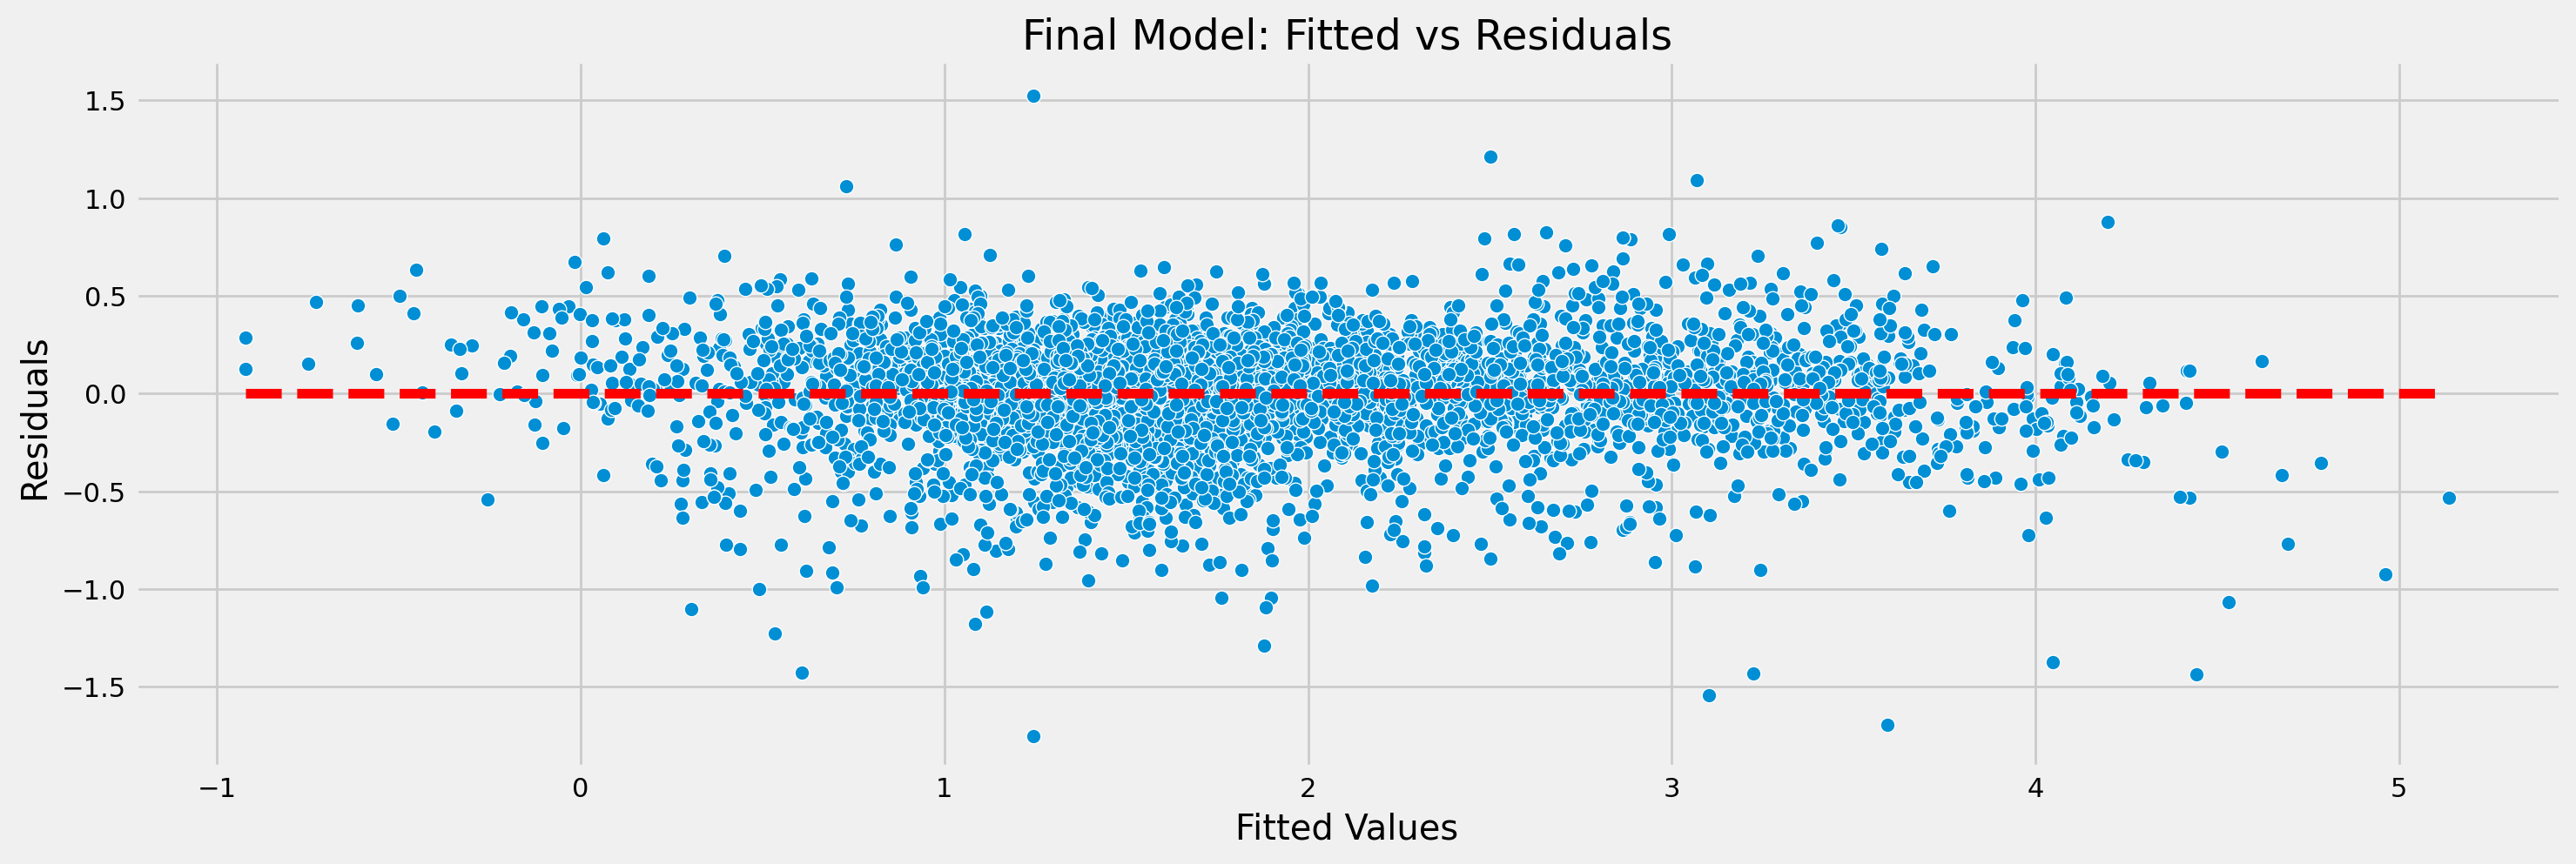

In [25]:
residuals = y_train['price_lakh_log'] - predicted_y_train
sns.scatterplot(x=predicted_y_train, y=residuals)
plt.hlines(y=0, xmin=np.min(predicted_y_train), xmax=np.max(predicted_y_train), color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Final Model: Fitted vs Residuals')
plt.show()

__Residuals Normality__

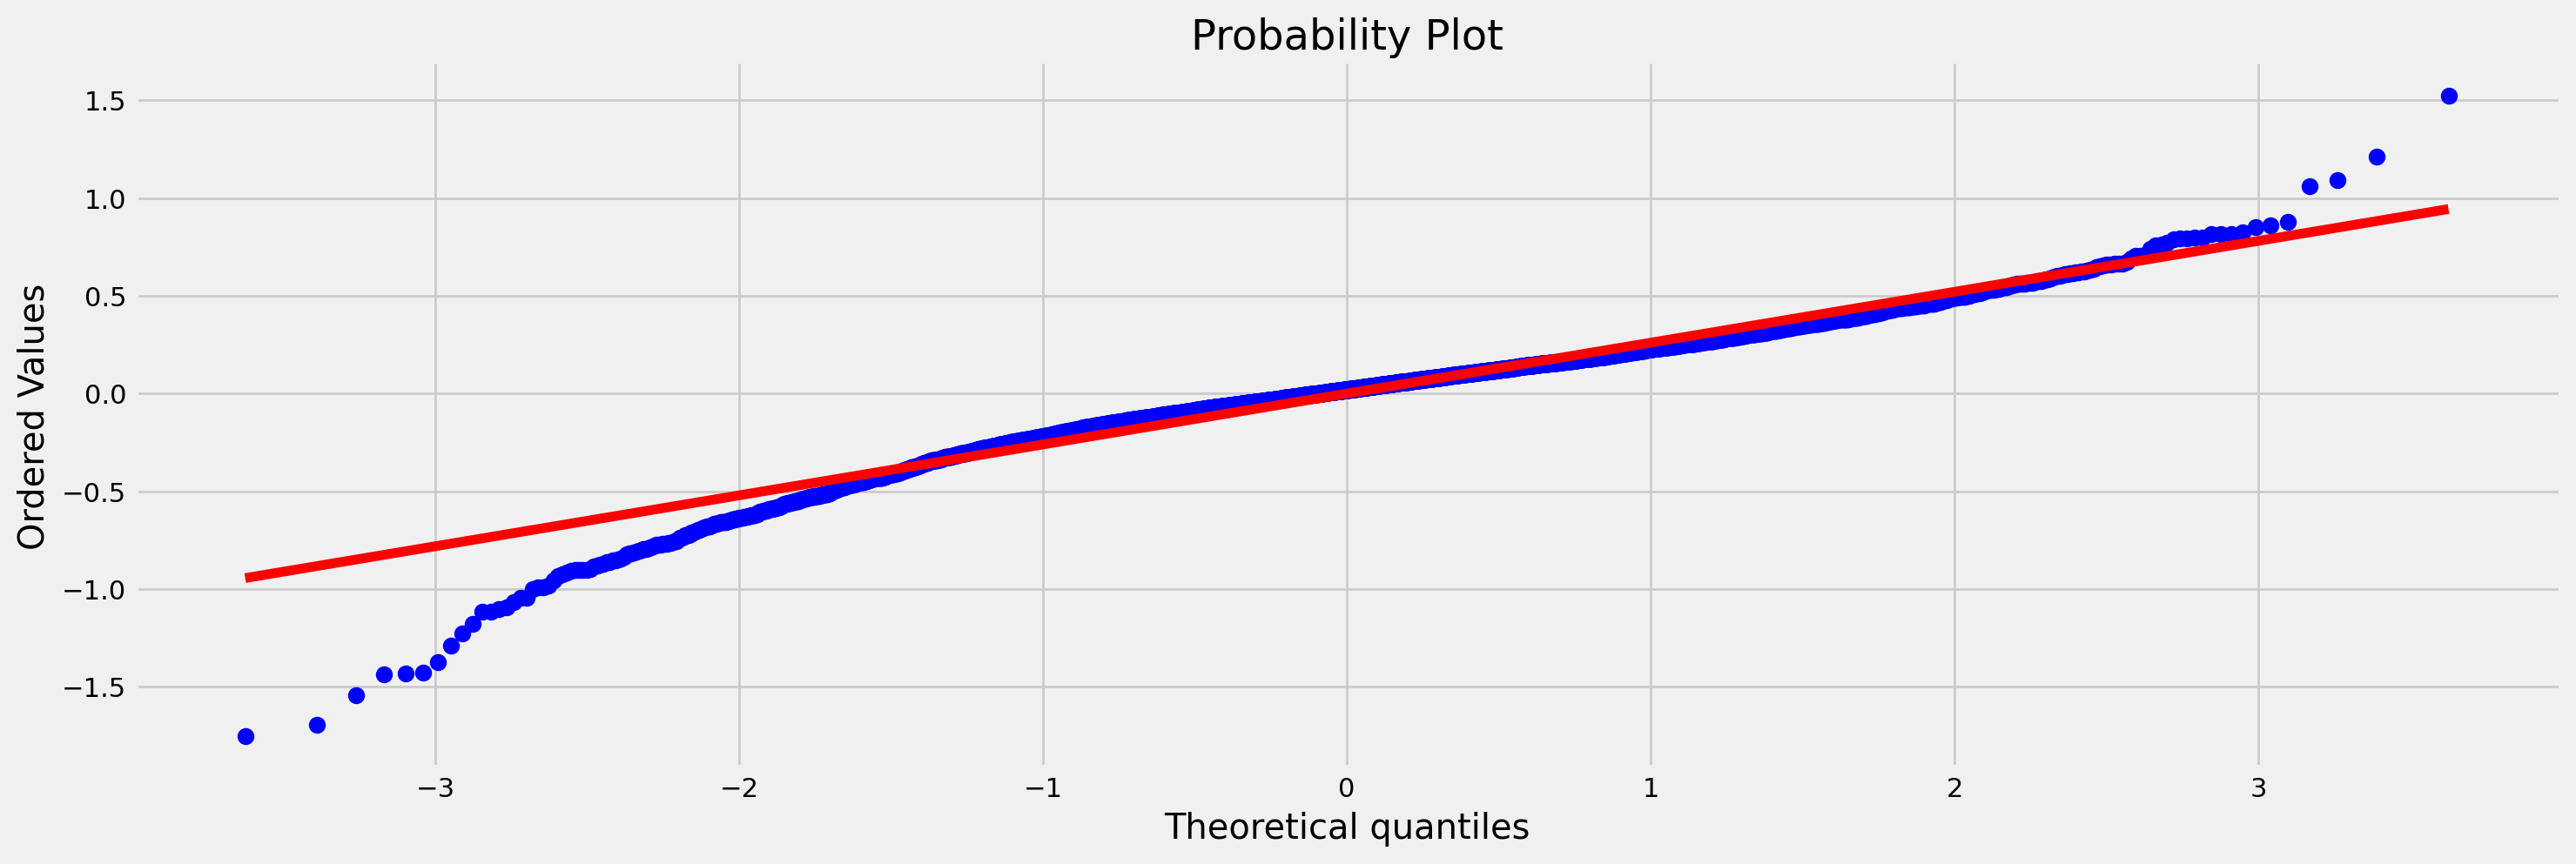

In [26]:
# QQ-plot
import scipy.stats as stats
import pylab

stats.probplot(residuals, dist = "norm", plot = pylab)
plt.show()

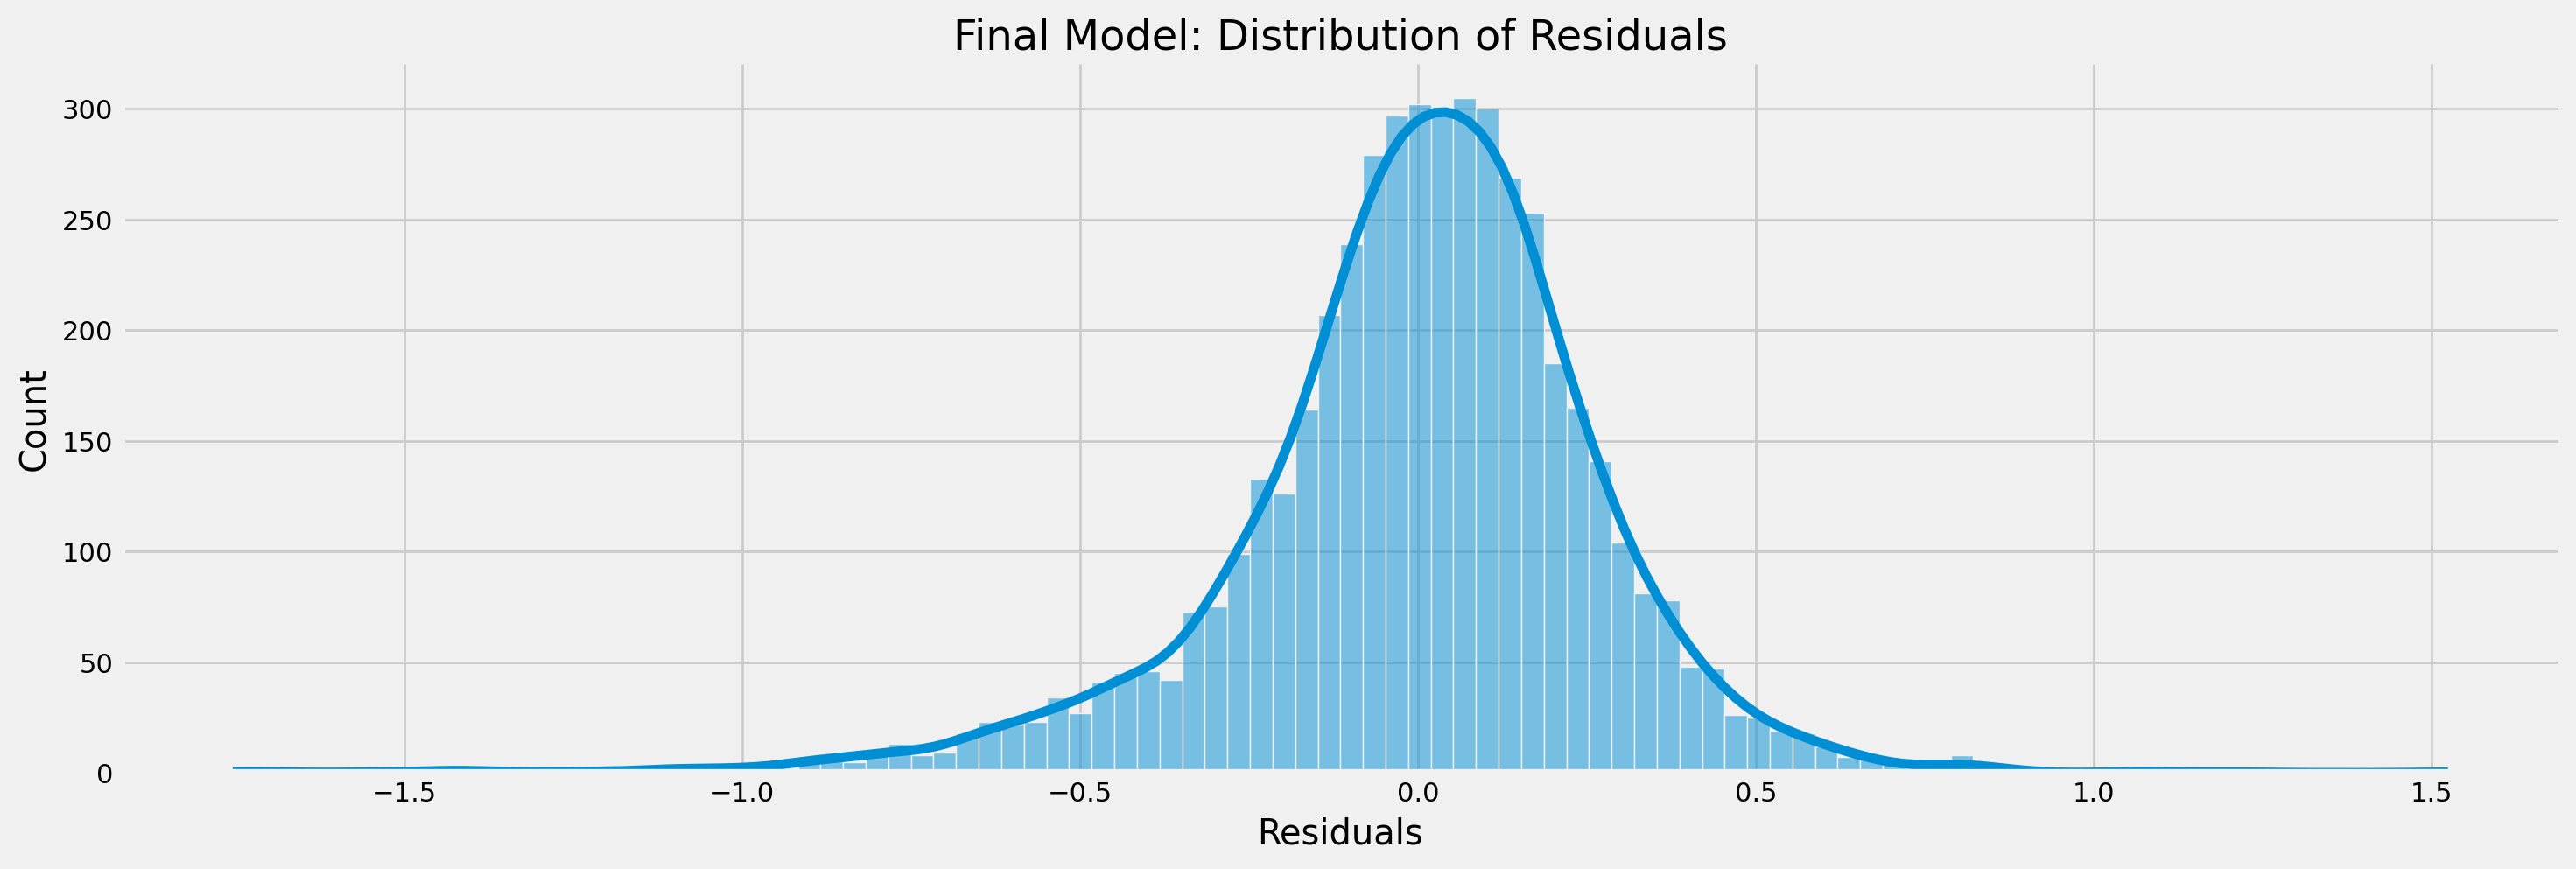

In [27]:
sns.histplot(residuals, kde=True)
plt.title('Final Model: Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

Use more formal Shapiro-Wilk Test to assess the normality of residuals.

- __Null Hypothesis ($H_0$):__ The residuals are normally distributed.
- __Alternative Hypothesis ($H_1$):__ The residuals are not normally distributed.

In [28]:
from scipy.stats import shapiro

test_statistic, p_value = shapiro(residuals)
print(f'Test Statistic: {test_statistic}, p-value: {p_value}')

Test Statistic: 0.9584921616864936, p-value: 5.298532091073767e-35


__p-value__ < 0.05 so we reject $H_0$, However, upon examining the histogram and Q-Q plot, we can observe that the distribution of residuals appears to be close to a normal distribution.

__Mean of Residuals__

In [29]:
print(f'Mean of Residuals : {np.mean(residuals):.15f}')

Mean of Residuals : -0.000000000000005


__Heteroscedasticity__

Use Goldfeldquandt Test to detect heteroskedasticity in residuals.

- __Null Hypothesis ($H_0$):__ There is __Homoskedasticity__ in the Residuals.
- __Alternative Hypothesis ($H_1$):__ There is __Heteroskedasticity__ in the Residuals.

In [30]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

f_statistic, p_value, _ = sms.het_goldfeldquandt(residuals, X_train)

print(f'F-statistic: {f_statistic}, p-value: {p_value:.8f}')

F-statistic: 0.9246091226157739, p-value: 0.97203308


__p-value__ > 0.05 so we cannot reject $H_0$.

### Model Viz <a name='model-viz'></a>

#### Actual vs Fitted

In [31]:
def actual_fitted(X, y, y_pred, name):
    _, r_2_adj = R2(X, y, y_pred)
    df_plot = pd.DataFrame({'Actual': y, 'Fitted': y_pred})
    sns.scatterplot(x='Actual', y='Fitted', data=df_plot)
    plt.plot([df_plot['Actual'].min(), df_plot['Actual'].max()], \
             [df_plot['Actual'].min(), df_plot['Actual'].max()], color='red', linestyle='--')
    plt.title(f'Actual vs Fitted Values on {name} Set')
    plt.annotate(f'R²adj. Score: {round(r_2_adj*100, 1)}%', xy =(-0.5, 3.5), 
                xytext =(-0.5, 3.5), fontsize=20) 
    plt.show()

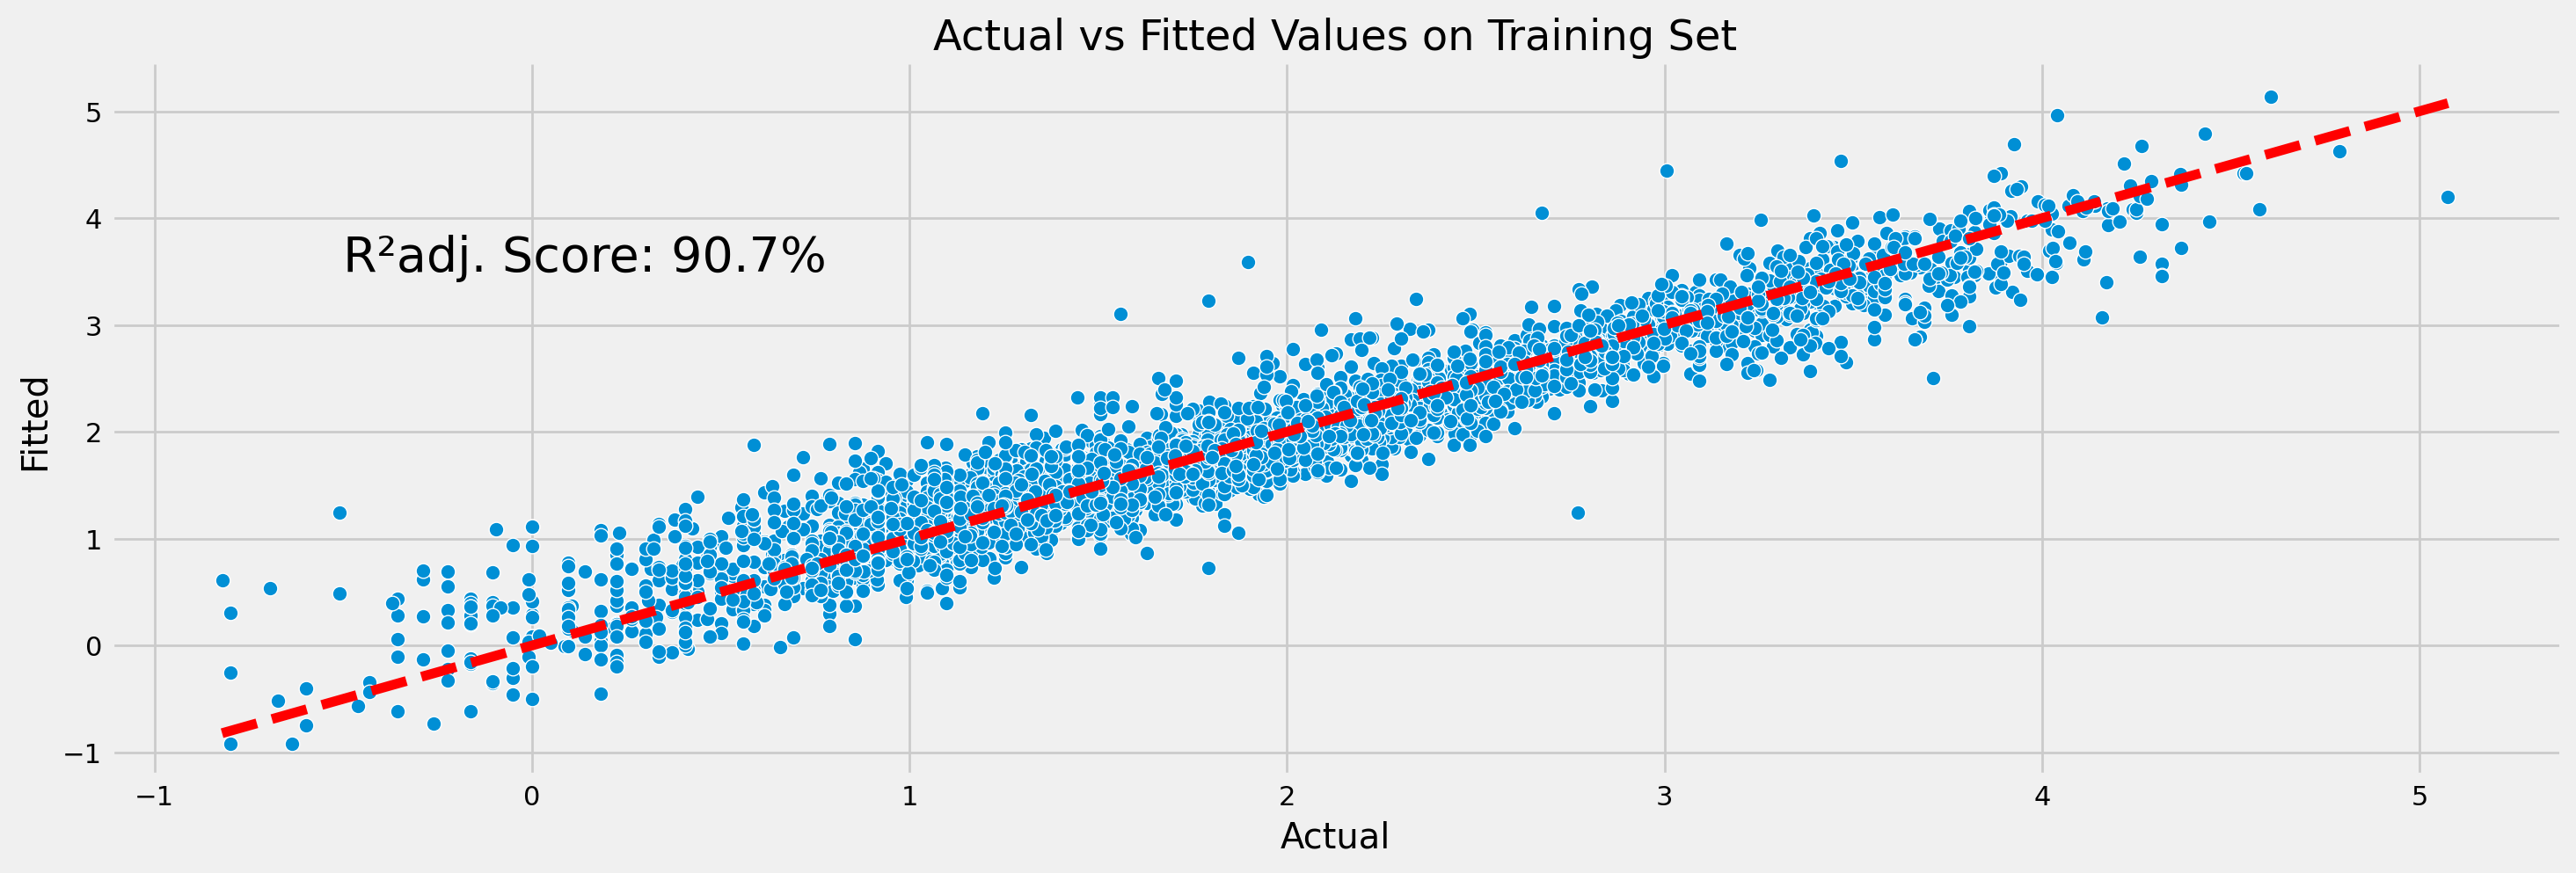

In [32]:
actual_fitted(xTrain, y_train['price_lakh_log'], predicted_y_train, 'Training')

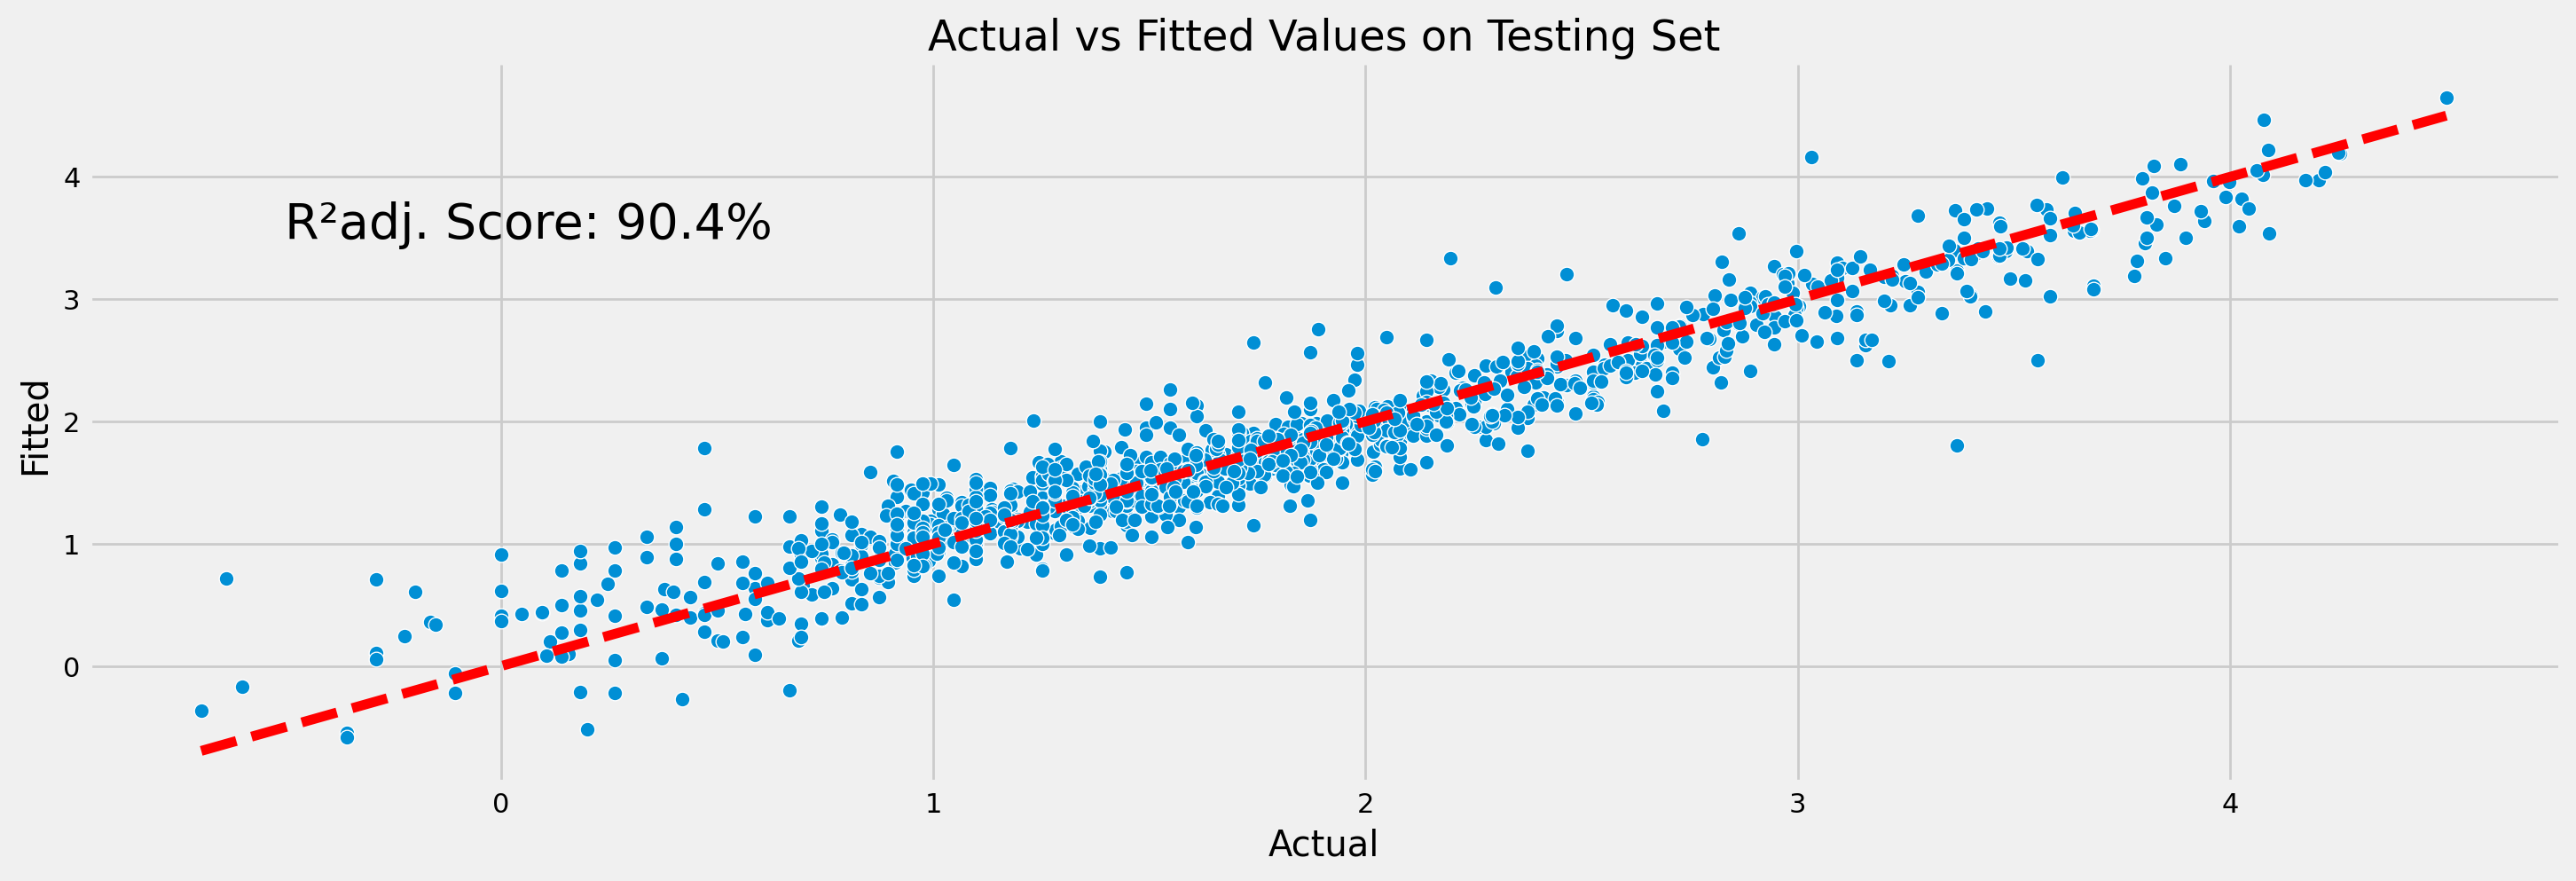

In [45]:
actual_fitted(xTest, y_test['price_lakh_log'], y_pred, 'Testing')

In [50]:
def coef_importance(model):
    # Coefficients Importance
    coef = model.params
    conf = model.conf_int()
    conf.columns = ['2.5%', '97.5%']
    conf['Coef'] = coef
    
    coef_df = conf.reset_index()
    coef_df.columns = ['Feature', 'Lower CI', 'Upper CI', 'Coefficient']
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df, errorbar=None, palette="Blues_d", hue='Feature')
    plt.errorbar(x=coef_df['Coefficient'], y=coef_df['Feature'],
                 xerr=(coef_df['Coefficient'] - coef_df['Lower CI'], coef_df['Upper CI'] - coef_df['Coefficient']),
                 fmt='o', color='black', capsize=5)
    
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Coefficients and Their Importance')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.grid(True)
    plt.show()

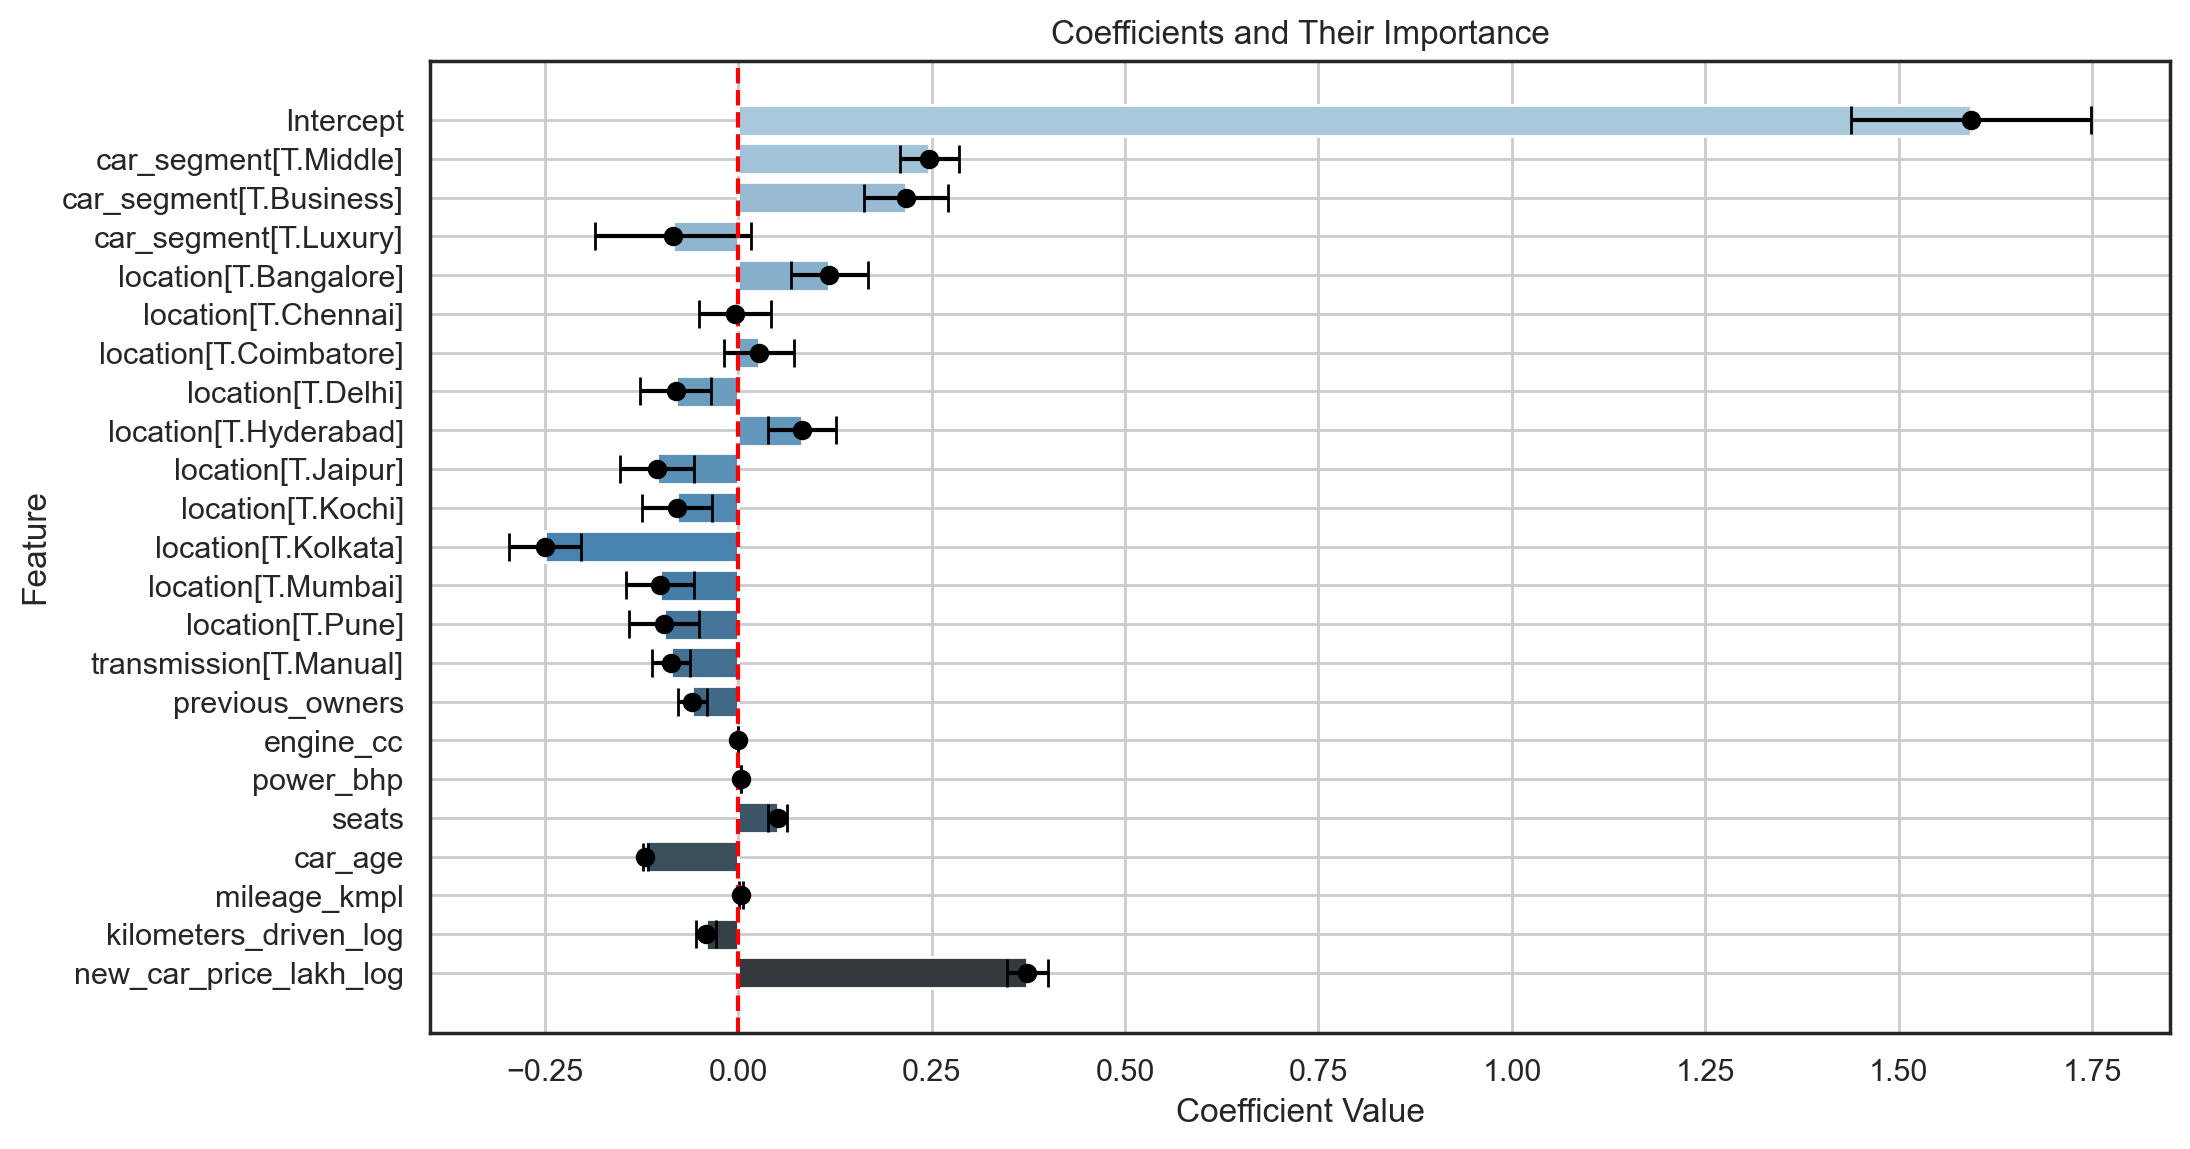

In [51]:
coef_importance(final_model)

## Model Interpretation <a name='model-interpretation'></a>

Prepare the information needed to interpret the model predictors.

In [36]:
# model summary
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_lakh_log   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     2136.
Date:                Sat, 03 Aug 2024   Prob (F-statistic):               0.00
Time:                        00:54:36   Log-Likelihood:                -453.57
No. Observations:                4812   AIC:                             953.1
Df Residuals:                    4789   BIC:                             1102.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.5937      0.079     20.171      0.000       1.439       1.749
car_segment[T.Middle]       0.2474      0.020     12.588      0.000       0.209       0.286
car_segment[T.Business]     0.2169      0.028      7.825      0.000       0.163       0.271
car_segment[T.Luxury]      -0.0836      0.051     -1.624      0.104      -0.184       0.017
location[T.Bangalore]       0.1178      0.025      4.661      0.000       0.068       0.167
location[T.Chennai]        -0.0041      0.024     -0.173      0.862      -0.051       0.042
location[T.Coimbatore]      0.0268      0.023      1.167      0.243      -0.018       0.072
location[T.Delhi]          -0.0807      0.023     -3.463      0.001      -0.126      -0.035
location[T.Hyderabad]       0.0829      0.022      3.714      0.000       0.039       0.127
location[T.Jaipur]         -0.1051      0.024     -4.318      0.000      -0.153      -0.057
location[T.Kochi]          -0.0788      0.023     -3.421      0.001      -0.124      -0.034
location[T.Kolkata]        -0.2493      0.024    -10.573      0.000      -0.296      -0.203
location[T.Mumbai]         -0.1010      0.022     -4.530      0.000      -0.145      -0.057
location[T.Pune]           -0.0954      0.023     -4.154      0.000      -0.140      -0.050
transmission[T.Manual]     -0.0865      0.013     -6.785      0.000      -0.111      -0.061
previous_owners            -0.0592      0.009     -6.292      0.000      -0.078      -0.041
engine_cc                   0.0002   1.79e-05     10.531      0.000       0.000       0.000
power_bhp                   0.0040      0.000     18.697      0.000       0.004       0.004
seats                       0.0511      0.006      8.008      0.000       0.039       0.064
car_age                    -0.1201      0.002    -72.361      0.000      -0.123      -0.117
mileage_kmpl                0.0041      0.001      3.405      0.001       0.002       0.006
kilometers_driven_log      -0.0416      0.007     -6.072      0.000      -0.055      -0.028
new_car_price_lakh_log      0.3740      0.014     27.065      0.000       0.347       0.401
==============================================================================
Omnibus:                      713.523   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2453.608
Skew:                          -0.734   Prob(JB):                         0.00
Kurtosis:                       6.175   Cond. No.                     3.75e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+04. This might indicate that there are
strong multicollinearity or other num

In [37]:
print(f'--- FINAL MODEL METRICS ---')
print(get_metrics(final_model, xTrain, y_train['price_lakh_log'], final_model.fittedvalues, \
                           xTest,  y_test['price_lakh_log'],  y_pred).T)
print(f'\nAIC={final_model.aic}, BIC={final_model.bic}')

--- FINAL MODEL METRICS ---
                                                 Training Set Testing Set
Sum of Squared Errors (SSE)                          340.1914     85.4336
Mean Absolute Error (MAE)                              1.2140      1.2153
Mean Squared Error (MSE)                               1.0733      1.0735
Root Mean Squared Error (RMSE)                         1.0360      1.0361
Symmetric Mean Absolute Percentage Error (SMAPE)        15.9%       16.8%
R^2                                                    0.9075      0.9061
Adjusted R^2                                           0.9071      0.9044

AIC=953.1462126627539, BIC=1102.160178435929


1. Approximately __91__% of variance of used car price explained by the predictors in the model.
2. Approximately __1.21 Lakh__ is average prediction error.
3. The model predicts incorrectly in approximately __16__% of all observations.

In [38]:
# intercept interpretation
intercept_df = pd.DataFrame(columns=['column', 'value'])
intercept = xTrain.columns.str.extract(r'(\w+)\[T\.(\w+)\]')[0]
intercept_df['column'] = intercept[intercept.notna()].unique()
intercept_df['value'] = [data[col].sort_values().unique()[0] for col in intercept[intercept.notna()].unique()]
intercept_df

column      value
0   car_segment    Economy
1      location  Ahmedabad
2  transmission  Automatic

In [39]:
np.exp(1.5937)

np.float64(4.921926406959432)

4. The intercept of __1.5937__, when the dependent variable is log-transformed, indicates that the expected price of a used car in the __Economy__ segment with __Automatic__ transmission and located in __Ahmedabad__ is approximately __4.92 Lakh__ ($\exp^{1.5937} = 4.92$, or __4.92 Lakh__), assuming all other predictors are zero. However, this situation is logically unrealistic because having all other predictors equal to zero is not a meaningful scenario in practice.
5. **Numerical Predictors Effect:**
   - **Previous Owners:** An increase in the number of previous owners by 1 is associated with a decrease in the price of the used car by approximately __5.74__% ($\exp^{-0.0592} - 1 = -0.0574$, or __-5.74__%), assuming all other predictors remain constant.\
     The predictor `previous_owners` is statistically significant (p-value = 0.0000).
   - **Engine CC:** An increase in engine CC by 1 unit is associated with an increase in the price of the used car by approximately __0.02__% ($\exp^{0.0002} - 1 = 0.0002$, or __0.02__%), assuming all other predictors remain constant.\
     The predictor `engine_cc` is statistically significant (p-value = 0.0000).
   - **Power BHP:** An increase in power bhp by 1 unit is associated with an increase in the price of the used car by approximately __0.40__% ($\exp^{0.0040} - 1 = 0.0040$, or __0.40__%), assuming all other predictors remain constant.\
     The predictor `power_bhp` is statistically significant (p-value = 0.0000).
   - **Seats:** An increase in the number of seats by 1 is associated with an increase in the price of the used car by approximately __5.25__% ($\exp^{0.0511} - 1 = 0.0525$, or __5.25__%), assuming all other predictors remain constant.\
     The predictor `seats` is statistically significant (p-value = 0.0000).
   - **Car Age:** An increase in car age by 1 year is associated with a decrease in the price of the used car by approximately __11.32__% ($\exp^{-0.1201} - 1 = -0.1132$, or __-11.32__%), assuming all other predictors remain constant. \
     The predictor `car_age` is statistically significant (p-value = 0.0000).
   - **Mileage (kmpl):** An increase in mileage by 1 kmpl is associated with an increase in the price of the used car by approximately __0.41__% ($\exp^{0.0041} - 1 = 0.0041$, or __0.41__%), assuming all other predictors remain constant.\
     The predictor `mileage_kmpl` is statistically significant (p-value = 0.0007).
   - **Kilometers Driven (Log):** An increase in kilometers driven by 1% is associated with a decrease in the price of the used car by approximately __0.04__%, assuming all other predictors remain constant.\
     The predictor `kilometers_driven_log` is statistically significant (p-value = 0.0000).
   - **New Car Price (Log):** An increase in the new car price by 1% is associated with an increase in the price of the used car by approximately __0.37__%, assuming all other predictors remain constant.\
     The predictor `new_car_price_lakh_log` is statistically significant (p-value = 0.0000).
6. **Transmission Effect:**
   - **Manual:** Moving from __Automatic__ to __Manual__ transmission, the price of a used car is expected to decrease by approximately __8.29__% ($\exp^{-0.0865} - 1 = -0.0829$, or __-8.29__%), assuming all other predictors remain constant.\
     The predictor `transmission[T.Manual]` is statistically significant (p-value = 0.0000).
7. **Location Effects:**
   - **Bangalore:** Moving from __Ahmedabad__ to __Bangalore__, the price of a used car is expected to increase by approximately __12.51__% ($\exp^{0.1178} - 1 = 0.1251$, or __12.51__%), assuming all other predictors remain constant.\
     The predictor `location[T.Bangalore]` is statistically significant (p-value = 0.0000).
   - **Chennai:** Moving from __Ahmedabad__ to __Chennai__, the price of a used car is expected to decrease by approximately __0.41__% ($\exp^{-0.0041} - 1 = -0.0041$, or __-0.41__%), assuming all other predictors remain constant.\
     The predictor `location[T.Chennai]` is statistically insignificant (p-value = 0.8624).
   - **Coimbatore:** Moving from __Ahmedabad__ to __Coimbatore__, the price of a used car is expected to increase by approximately __2.71__% ($\exp^{0.0268} - 1 = 0.0271$, or __2.71__%), assuming all other predictors remain constant.\
     The predictor `location[T.Coimbatore]` is statistically insignificant (p-value = 0.2433).
   - **Delhi:** Moving from __Ahmedabad__ to __Delhi__, the price of a used car is expected to decrease by approximately __7.75__% ($\exp^{-0.0807} - 1 = -0.0775$, or __-7.75__%), assuming all other predictors remain constant.\
     The predictor `location[T.Delhi]` is statistically significant (p-value = 0.0005).
   - **Hyderabad:** Moving from __Ahmedabad__ to __Hyderabad__, the price of a used car is expected to increase by approximately __8.64__% ($\exp^{0.0829} - 1 = 0.0864$, or __8.64__%), assuming all other predictors remain constant.\
     The predictor `location[T.Hyderabad]` is statistically significant (p-value = 0.0002).
   - **Jaipur:** Moving from __Ahmedabad__ to __Jaipur__, the price of a used car is expected to decrease by approximately __9.98__% ($\exp^{-0.1051} - 1 = -0.0998$, or __-9.98__%), assuming all other predictors remain constant.\
     The predictor `location[T.Jaipur]` is statistically significant (p-value = 0.0000).
   - **Kochi:** Moving from __Ahmedabad__ to __Kochi__, the price of a used car is expected to decrease by approximately __7.58__% ($\exp^{-0.0788} - 1 = -0.0758$, or __-7.58__%), assuming all other predictors remain constant.\
     The predictor `location[T.Kochi]` is statistically significant (p-value = 0.0006).
   - **Kolkata:** Moving from __Ahmedabad__ to __Kolkata__, the price of a used car is expected to decrease by approximately __22.07__% ($\exp^{-0.2493} - 1 = -0.2207$, or __-22.07__%), assuming all other predictors remain constant.\
     The predictor `location[T.Kolkata]` is statistically significant (p-value = 0.0000).
   - **Mumbai:** Moving from __Ahmedabad__ to __Mumbai__, the price of a used car is expected to decrease by approximately __9.61__% ($\exp^{-0.1010} - 1 = -0.0961$, or __-9.61__%), assuming all other predictors remain constant.\
     The predictor `location[T.Mumbai]` is statistically significant (p-value = 0.0000).
   - **Pune:** Moving from __Ahmedabad__ to __Pune__, the price of a used car is expected to decrease by approximately __9.10__% ($\exp^{-0.0954} - 1 = -0.0910$, or __-9.10__%), assuming all other predictors remain constant.\
     The predictor `location[T.Pune]` is statistically significant (p-value = 0.0000).
8. **Car Segment Effects:**
   - **Middle:** Moving from the __Economy__ segment to the __Middle__ segment, the price of a used car is expected to increase by approximately __28.07__% ($\exp^{0.2474} - 1 = 0.2807$, or __28.07__%), assuming all other predictors remain constant.\
     The predictor `car_segment[T.Middle]` is statistically significant (p-value = 0.0000).
   - **Business:** Moving from the __Economy__ segment to the __Business__ segment, the price of a used car is expected to increase by approximately __24.22__% ($\exp^{0.2169} - 1 = 0.2422$, or __24.22__%), assuming all other predictors remain constant.\
     The predictor `car_segment[T.Business]` is statistically significant (p-value = 0.0000).
   - **Luxury:** Moving from the __Economy__ segment to the __Luxury__ segment, the price of a used car is expected to decrease by approximately __8.02__% ($\exp^{-0.0836} - 1 = -0.0802$, or __-8.02__%), assuming all other predictors remain constant. The negative coefficient indicates that, according to the model, __Luxury__ cars have a lower price relative to __Economy__ cars when all other factors are held constant. This might seem counterintuitive, as __Luxury__ cars are typically more expensive new, but it reflects the specific patterns and relationships in the data used for the model.\
     The predictor `car_segment[T.Luxury]` is statistically insignificant (p-value = 0.1044).
   
#### General Notes:
- **Statistical Significance:** Coefficients with p-values less than 0.05 are considered statistically significant.
- **Effect Sizes:** For variables where the dependent variable is log-transformed, the percentage changes are derived from the exponential of the coefficient, i.e., `exp(coef) - 1`.


## Predict New Data <a name='predict-new-data'></a>

In [40]:
# predict missing price on new Data
X_predict = X_predict.loc[:, ~X_predict.columns.str.startswith('fuel_type')]
X_predict.head()

Intercept  car_segment[T.Middle]  car_segment[T.Business]  \
6019     1.0000                 0.0000                   0.0000   
6020     1.0000                 0.0000                   0.0000   
6021     1.0000                 0.0000                   0.0000   
6022     1.0000                 0.0000                   0.0000   
6023     1.0000                 0.0000                   0.0000   

      car_segment[T.Luxury]  location[T.Bangalore]  location[T.Chennai]  \
6019                 0.0000                 0.0000               0.0000   
6020                 0.0000                 0.0000               0.0000   
6021                 0.0000                 0.0000               0.0000   
6022                 0.0000                 0.0000               0.0000   
6023                 0.0000                 0.0000               0.0000   

      location[T.Coimbatore]  location[T.Delhi]  location[T.Hyderabad]  \
6019                  0.0000             1.0000                 0.0000   
6020                  1.0000             0.0000                 0.0000   
6021                  0.0000             0.0000                 0.0000   
6022                  0.0000             0.0000                 1.0000   
6023                  0.0000             0.0000                 0.0000   

      location[T.Jaipur]  location[T.Kochi]  location[T.Kolkata]  \
6019              0.0000             0.0000               0.0000   
6020              0.0000             0.0000               0.0000   
6021              0.0000             0.0000               0.0000   
6022              0.0000             0.0000               0.0000   
6023              0.0000             0.0000               0.0000   

      location[T.Mumbai]  location[T.Pune]  transmission[T.Manual]  \
6019              0.0000            0.0000                  1.0000   
6020              0.0000            0.0000                  1.0000   
6021              1.0000            0.0000                  1.0000   
6022              0.0000            0.0000                  1.0000   
6023              1.0000            0.0000                  1.0000   

      previous_owners  engine_cc  power_bhp  seats  car_age  mileage_kmpl  \
6019           1.0000   998.0000    58.2000 4.0000  10.0000        5.9681   
6020           2.0000   796.0000    47.3000 5.0000  11.0000       24.7000   
6021           1.0000 2,393.0000   147.8000 7.0000   7.0000       13.6800   
6022           1.0000 1,364.0000    78.9000 5.0000  12.0000       23.5900   
6023           1.0000 1,197.0000    82.8500 5.0000  10.0000       18.5000   

      kilometers_driven_log  new_car_price_lakh_log  
6019                10.6196                  1.4818  
6020                10.9058                  1.4500  
6021                10.4341                  3.2296  
6022                11.8422                  2.1650  
6023                10.2751                  2.2920

In [41]:
# the dependent variable is log-transformed, so we need to EXP the predicted values
data.loc[data['price_lakh'].isna(), 'price_lakh'] = np.exp(final_model.predict(X_predict))

In [42]:
data.columns

Index(['location', 'year', 'kilometers_driven', 'fuel_type', 'transmission',
       'owner_type', 'engine_cc', 'power_bhp', 'seats', 'price_lakh', 'brand',
       'model', 'mileage_kmpl', 'new_car_price_lakh', 'previous_owners',
       'car_age', 'car_segment', 'kilometers_driven_log', 'price_lakh_log',
       'new_car_price_lakh_log'],
      dtype='object')

In [43]:
filled_data = data.drop(columns=['kilometers_driven_log', 
                   'price_lakh_log', 
                   'new_car_price_lakh_log'])

filled_data.isna().sum()

location              0
year                  0
kilometers_driven     0
fuel_type             0
transmission          0
owner_type            0
engine_cc             0
power_bhp             0
seats                 0
price_lakh            0
brand                 0
model                 0
mileage_kmpl          0
new_car_price_lakh    0
previous_owners       0
car_age               0
car_segment           0
dtype: int64

## Save Final Model <a name='save-model'></a>

In [44]:
import pickle

final_model_filename = '../03_models/Cars4u_linear_regression_model.pkl'
pickle.dump(final_model, open(final_model_filename, 'wb'))


---
\
[__<< Feature Engineering__](./04-Cars4u_feature_engineering.ipynb) | [__Home__](../README.md)

\
\
Cars4u: Car Price Prediction, _August 2024_